<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from tqdm import tqdm

random.seed(42)
np.random.seed(42)

### **Задание 0**
Для чего фиксируем сиды в домашках?



`Для воспроизводимости результата. Чтобы проверяющие могли запустить ноутбук и получить такие же результаты `

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [36]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [3]:
# your code here
df_train.isna().sum(), df_test.isna().sum()

(name               0
 year               0
 selling_price      0
 km_driven          0
 fuel               0
 seller_type        0
 transmission       0
 owner              0
 mileage          202
 engine           202
 max_power        196
 torque           203
 seats            202
 dtype: int64,
 name              0
 year              0
 selling_price     0
 km_driven         0
 fuel              0
 seller_type       0
 transmission      0
 owner             0
 mileage          19
 engine           19
 max_power        19
 torque           19
 seats            19
 dtype: int64)

In [4]:
df_train.duplicated().sum(), df_test.duplicated().sum() 

(985, 62)

явные дубликаты

In [5]:
duplicates = df_train[df_train.duplicated(keep=False)]
duplicates[duplicates['year'] == 2003]

name  year  selling_price  km_driven    fuel seller_type  \
28    Fiat Palio 1.2 ELX  2003          70000      50000  Petrol  Individual   
6495  Fiat Palio 1.2 ELX  2003          70000      50000  Petrol  Individual   

     transmission         owner mileage engine max_power torque  seats  
28         Manual  Second Owner     NaN    NaN       NaN    NaN    NaN  
6495       Manual  Second Owner     NaN    NaN       NaN    NaN    NaN

In [37]:
from ydata_profiling import ProfileReport

profile_report = ProfileReport(df_train, title='Pandas Profiling Report')

In [38]:
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

```Выводы: По дашборду можно увидеть, что в данных есть пропуски и дубликаты от которых стоит избавиться. Так как пропусков немного, можно их выкинуть, либо заполнить какой то статистикой, но для каждого признака по своему. Есть 3 вида признаков: числовые категориальные и текстовые. Необходимо обратить внимание на коррелирующие признаки с таргетом, для интерпретации модели и выдвижение гипотез. Есть несбалансированный признак, нужно убедиться, что в трейн попали все категории из данного признака (рассмотрел ниже)```

In [8]:
print(df_train.seller_type.unique())
print(df_test.seller_type.unique())

['Individual' 'Dealer' 'Trustmark Dealer']
['Individual' 'Dealer' 'Trustmark Dealer']


### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [9]:
# your code here
df_train.describe()

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [10]:
df_test.describe()

year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

In [11]:
df_train.describe(include=['O'])

name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power          torque  
count        6797     6797      6803            6796  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          197      885       330             468

In [12]:
df_test.describe(include=['O'])

name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

```В колонках selling_price	и km_driven	медиана ниже среднего, это может говорить либо о наличии выбросов, либо просто о разном распределении данных, например, разный уровень качества машин (если, конечно, нет выбросов)```

### **Задание 3 (0.2 балла)**

**Ваши действия:**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [3]:
# your code here
X, y = df_train.drop(['selling_price'], axis=1), df_train['selling_price']

data = X[X.duplicated(keep=False)]
data_sort = data.sort_values(by=list(data.columns))
print(f"Всего {data.shape[0]} объектов с одинаковым признаковым описанием")
data_sort

Всего 1799 объектов с одинаковым признаковым описанием


name  year  km_driven    fuel  \
1703  Audi Q3 2.0 TDI Quattro Premium Plus  2017      22000  Diesel   
6307  Audi Q3 2.0 TDI Quattro Premium Plus  2017      22000  Diesel   
1836               Audi Q5 3.0 TDI Quattro  2014      76131  Diesel   
6704               Audi Q5 3.0 TDI Quattro  2014      76131  Diesel   
117             Audi Q5 35TDI Premium Plus  2018      31800  Diesel   
...                                    ...   ...        ...     ...   
5637        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
5652        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
5753        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
5991        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
6778        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   

     seller_type transmission        owner     mileage   engine   max_power  \
1703      Dealer    Automatic  First Owner  15.73 kmpl  1968 CC  174.33 bhp   
6307      Dealer    Automatic  First Owner  15.73 kmpl  1968 CC  174.33 bhp   
1836  Individual    Automatic  First Owner  13.22 kmpl  2967 CC   241.4 bhp   
6704  Individual    Automatic  First Owner  13.22 kmpl  2967 CC   241.4 bhp   
117       Dealer    Automatic  First Owner  17.01 kmpl  1968 CC     188 bhp   
...          ...          ...          ...         ...      ...         ...   
5637  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
5652  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
5753  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
5991  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
6778  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   

                   torque  seats  
1703  380Nm@ 1750-2500rpm    5.0  
6307  380Nm@ 1750-2500rpm    5.0  
1836  580Nm@ 1400-3250rpm    5.0  
6704  580Nm@ 1400-3250rpm    5.0  
117   400nm@ 1750-3000rpm    5.0  
...                   ...    ...  
5637                400Nm    5.0  
5652                400Nm    5.0  
5753                400Nm    5.0  
5991                400Nm    5.0  
6778                400Nm    5.0  

[1799 rows x 12 columns]

In [4]:
def foo(X):
    X = X.fillna(0) # чтобы находить идентичные строки
    lst_unique = []
    for i in tqdm(range(X.drop_duplicates().shape[0])):
        elem = X.iloc[i]
        sub = X[X[list(elem.keys())] == pd.Series(elem)].dropna()
        sub = pd.DataFrame(sub.iloc[0]).T
        if sub.shape[0] == 1:
            lst_unique.append(sub)
        else:
            print(sub.shape, i)
            break
    return lst_unique
    
lst_data = foo(X)
X_2 = X.iloc[list(pd.concat(lst_data).index)]

100%|██████████| 5840/5840 [00:50<00:00, 114.57it/s]


In [7]:
y = y.iloc[list(X_2.index)]
y = y.reset_index(drop=True)
X_2 = X_2.reset_index(drop=True)
df_train = pd.concat([X_2, y], axis=1)

In [8]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [9]:
import re

Не хватает данных, чтобы перевести литры в кг))

In [10]:
df_train['mileage'].apply(lambda x: x.split()[1] if isinstance(x, str) else x).unique()

array(['kmpl', 'km/kg', nan], dtype=object)

In [11]:
# your code here
def transform(x):
    if isinstance(x, float):
        return x
    elif isinstance(x, str):
        try:
            x = re.search('\d+', x)[0]
        except Exception:
            print(x)
            return 0
        return x

cols = ['mileage', 'engine', 'max_power']
for col in cols:
    df_train[col] = df_train[col].apply(lambda x: transform(x))
    df_test[col] = df_test[col].apply(lambda x: transform(x))


df_train['mileage'] = df_train['mileage'].astype(float)
df_train['engine'] = df_train['engine'].astype(float)
df_train['max_power'] = df_train['max_power'].astype(float)

df_test['mileage'] = df_test['mileage'].astype(float)
df_test['engine'] = df_test['engine'].astype(float)
df_test['max_power'] = df_test['max_power'].astype(float)

 bhp


In [12]:
df_train['torque'].apply(lambda x: " ".join(re.findall(r"[a-zA-Z]+", x)) if isinstance(x, str) else x).unique()

array(['Nm rpm', 'kgm at rpm', 'kgm rpm', 'nm rpm', nan, 'rpm', 'Nm',
       'Nm at rpm', 'KGM at RPM', 'Nm kgm rpm', '', 'NM rpm'],
      dtype=object)

Есть элементы в torque у которых 3 слова, в таком случае исключаем at, далее если kgm, то первое число умножим на 9.8, иначе оставим как есть

Был найден единственный уникальный случай, где фигурировали сразу 2 единицы измерения: nm и kgm! Одна дполняла другую) поэтому такой случай также обрабатывается в коде)

Есть элементы без единицы измерения, я их честно вывел, посмотрел, и понял, что по своему значению они принадлежат единице измерения nm

In [13]:
def torque_transform(x, min=True):
    global cnt
    if x is np.nan:
        return x
    
    lst = re.findall(r"\d+[.,]*\d+", x)
    lst_s = re.findall(r"[a-zA-Z]+", x)

    for i in range(len(lst)):
        lst[i] = lst[i].replace(',', '.')

    if len(lst) > 2:
        mn = lst[0]
        mx = lst[-1]
    elif len(lst) == 2:
        mn = lst[0]
        mx = lst[1]
    else:
        mn = lst[0]
        mx = np.nan
        if not min:
            return mx

    if 'nm' in " ".join(lst_s).lower() and 'kgm' in " ".join(lst_s).lower():
        if lst_s[0].lower() == 'kgm':
            mn = 9.8*float(mn)

    #print(mn, x)
    if len(lst_s) >= 2:
        if lst_s[0].lower() == 'kgm':
            if min:
                return 9.8*float(mn)
            return mx
        else:
            if min:
                return mn
            return mx
    elif len(lst_s) == 1:
        if lst_s[0].lower() == 'rpm' or lst_s[0].lower() == 'nm':
            if min:
                return mn
            return mx
        elif lst_s[0].lower() == 'kgm':
            if min:
                return 9.8*float(mn)
            return mx
        else:
            print("не может быть")
    else:
        if min:
            return mn
        return mx

df_train['max_torque_rpm'] = df_train['torque'].apply(lambda x: torque_transform(x, min=False))
df_train['torque'] = df_train['torque'].apply(lambda x: torque_transform(x, min=True))

df_test['max_torque_rpm'] = df_test['torque'].apply(lambda x: torque_transform(x, min=False))
df_test['torque'] = df_test['torque'].apply(lambda x: torque_transform(x, min=True))

In [14]:
df_train['torque'] = df_train['torque'].astype(float)
df_train['max_torque_rpm'] = df_train['max_torque_rpm'].astype(float)

df_test['torque'] = df_test['torque'].astype(float)
df_test['max_torque_rpm'] = df_test['max_torque_rpm'].astype(float)

In [15]:
df_train[['max_torque_rpm', 'torque']].head()

max_torque_rpm  torque
0          2000.0  190.00
1          2500.0  250.00
2          2750.0  219.52
3             4.5  112.70
4          4000.0  113.75

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [16]:
# your code here
statistics = dict()
for col in df_train.columns:
    if df_train[col].dtype != 'object':
        statistica = df_train[col].median()
        df_train[col].fillna(statistica, inplace=True)
        df_test[col].fillna(statistica, inplace=True)

        statistics[col] = statistica

C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_18176\1702931495.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna(statistica, inplace=True)
C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_18176\1702931495.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [18]:
statistics

{'year': 2015.0,
 'km_driven': 60000.0,
 'mileage': 19.0,
 'engine': 1248.0,
 'max_power': 82.0,
 'torque': 170.0,
 'seats': 5.0,
 'selling_price': 450000.0,
 'max_torque_rpm': 3000.0}

In [62]:
import pickle
with open('statistics.pkl', 'rb') as f:
        statistics = pickle.load(f)


In [63]:
statistics

{'year': 2015.0,
 'km_driven': 60000.0,
 'mileage': 19.0,
 'engine': 1248.0,
 'max_power': 82.0,
 'torque': 170.0,
 'seats': 5.0,
 'selling_price': 450000.0,
 'max_torque_rpm': 3000.0}

In [17]:
df_train.shape

(5840, 14)

``Пропуски лучше заполнять медианой, так как она устойчивее к выбросам в данных нежели среднее. Также в данных может быть ассиметрия распределения, соответственно среднее  может не точно отображать центральное значение``

``Медиану праивльно считать: по тренировочным данным для train и test ``

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [20]:
# your code here
df_train['engine'] = df_train['engine'].astype(int)
df_train['seats'] = df_train['seats'].astype(int)

`причины, почему seats возможно рассмотреть как категориальную переменную:`

`1) В контексте задачи каждое значение seats может иметь собственное значение и смысл (вместимость автомобиля). Также можно разбить отрезок на подгруппы (small, medium, big)`

`2) При группировках и агрегациях может быть полезно рассматривать этот признак как категориальный`

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [27]:
df_train.describe()

year     km_driven      mileage       engine    max_power  \
count  5840.000000  5.840000e+03  5840.000000  5840.000000  5840.000000   
mean   2013.814726  6.959013e+04    18.943493  1454.628767    91.197089   
std       4.055733  5.952507e+04     4.005677   496.736208    35.783019   
min    1983.000000  1.000000e+03     0.000000   624.000000     0.000000   
25%    2011.000000  3.500000e+04    16.000000  1197.000000    68.000000   
50%    2015.000000  6.000000e+04    19.000000  1248.000000    82.000000   
75%    2017.000000  9.700000e+04    22.000000  1582.000000   101.000000   
max    2020.000000  2.360457e+06    42.000000  3604.000000   400.000000   

            torque        seats  selling_price  max_torque_rpm  
count  5840.000000  5840.000000   5.840000e+03     5840.000000  
mean    181.597610     5.408562   6.478546e+05     2950.074281  
std     111.933678     0.955167   8.371205e+05     1071.836035  
min      24.500000     2.000000   2.999900e+04        1.800000  
25%     113.000000     5.000000   2.500000e+05     2200.000000  
50%     170.000000     5.000000   4.500000e+05     3000.000000  
75%     205.000000     5.000000   6.750000e+05     4000.000000  
max    1862.000000    14.000000   1.000000e+07     5300.000000

`Оснований нет. Медиана точно осталась неизменной, среднее сдвинулось в сторону медианы. Да, распределение могло сдвинуться, если кол-во пропусков составляло бы большую долю и данные при этом были ассиметричны. Также уменьшилось бы std`

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.
- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

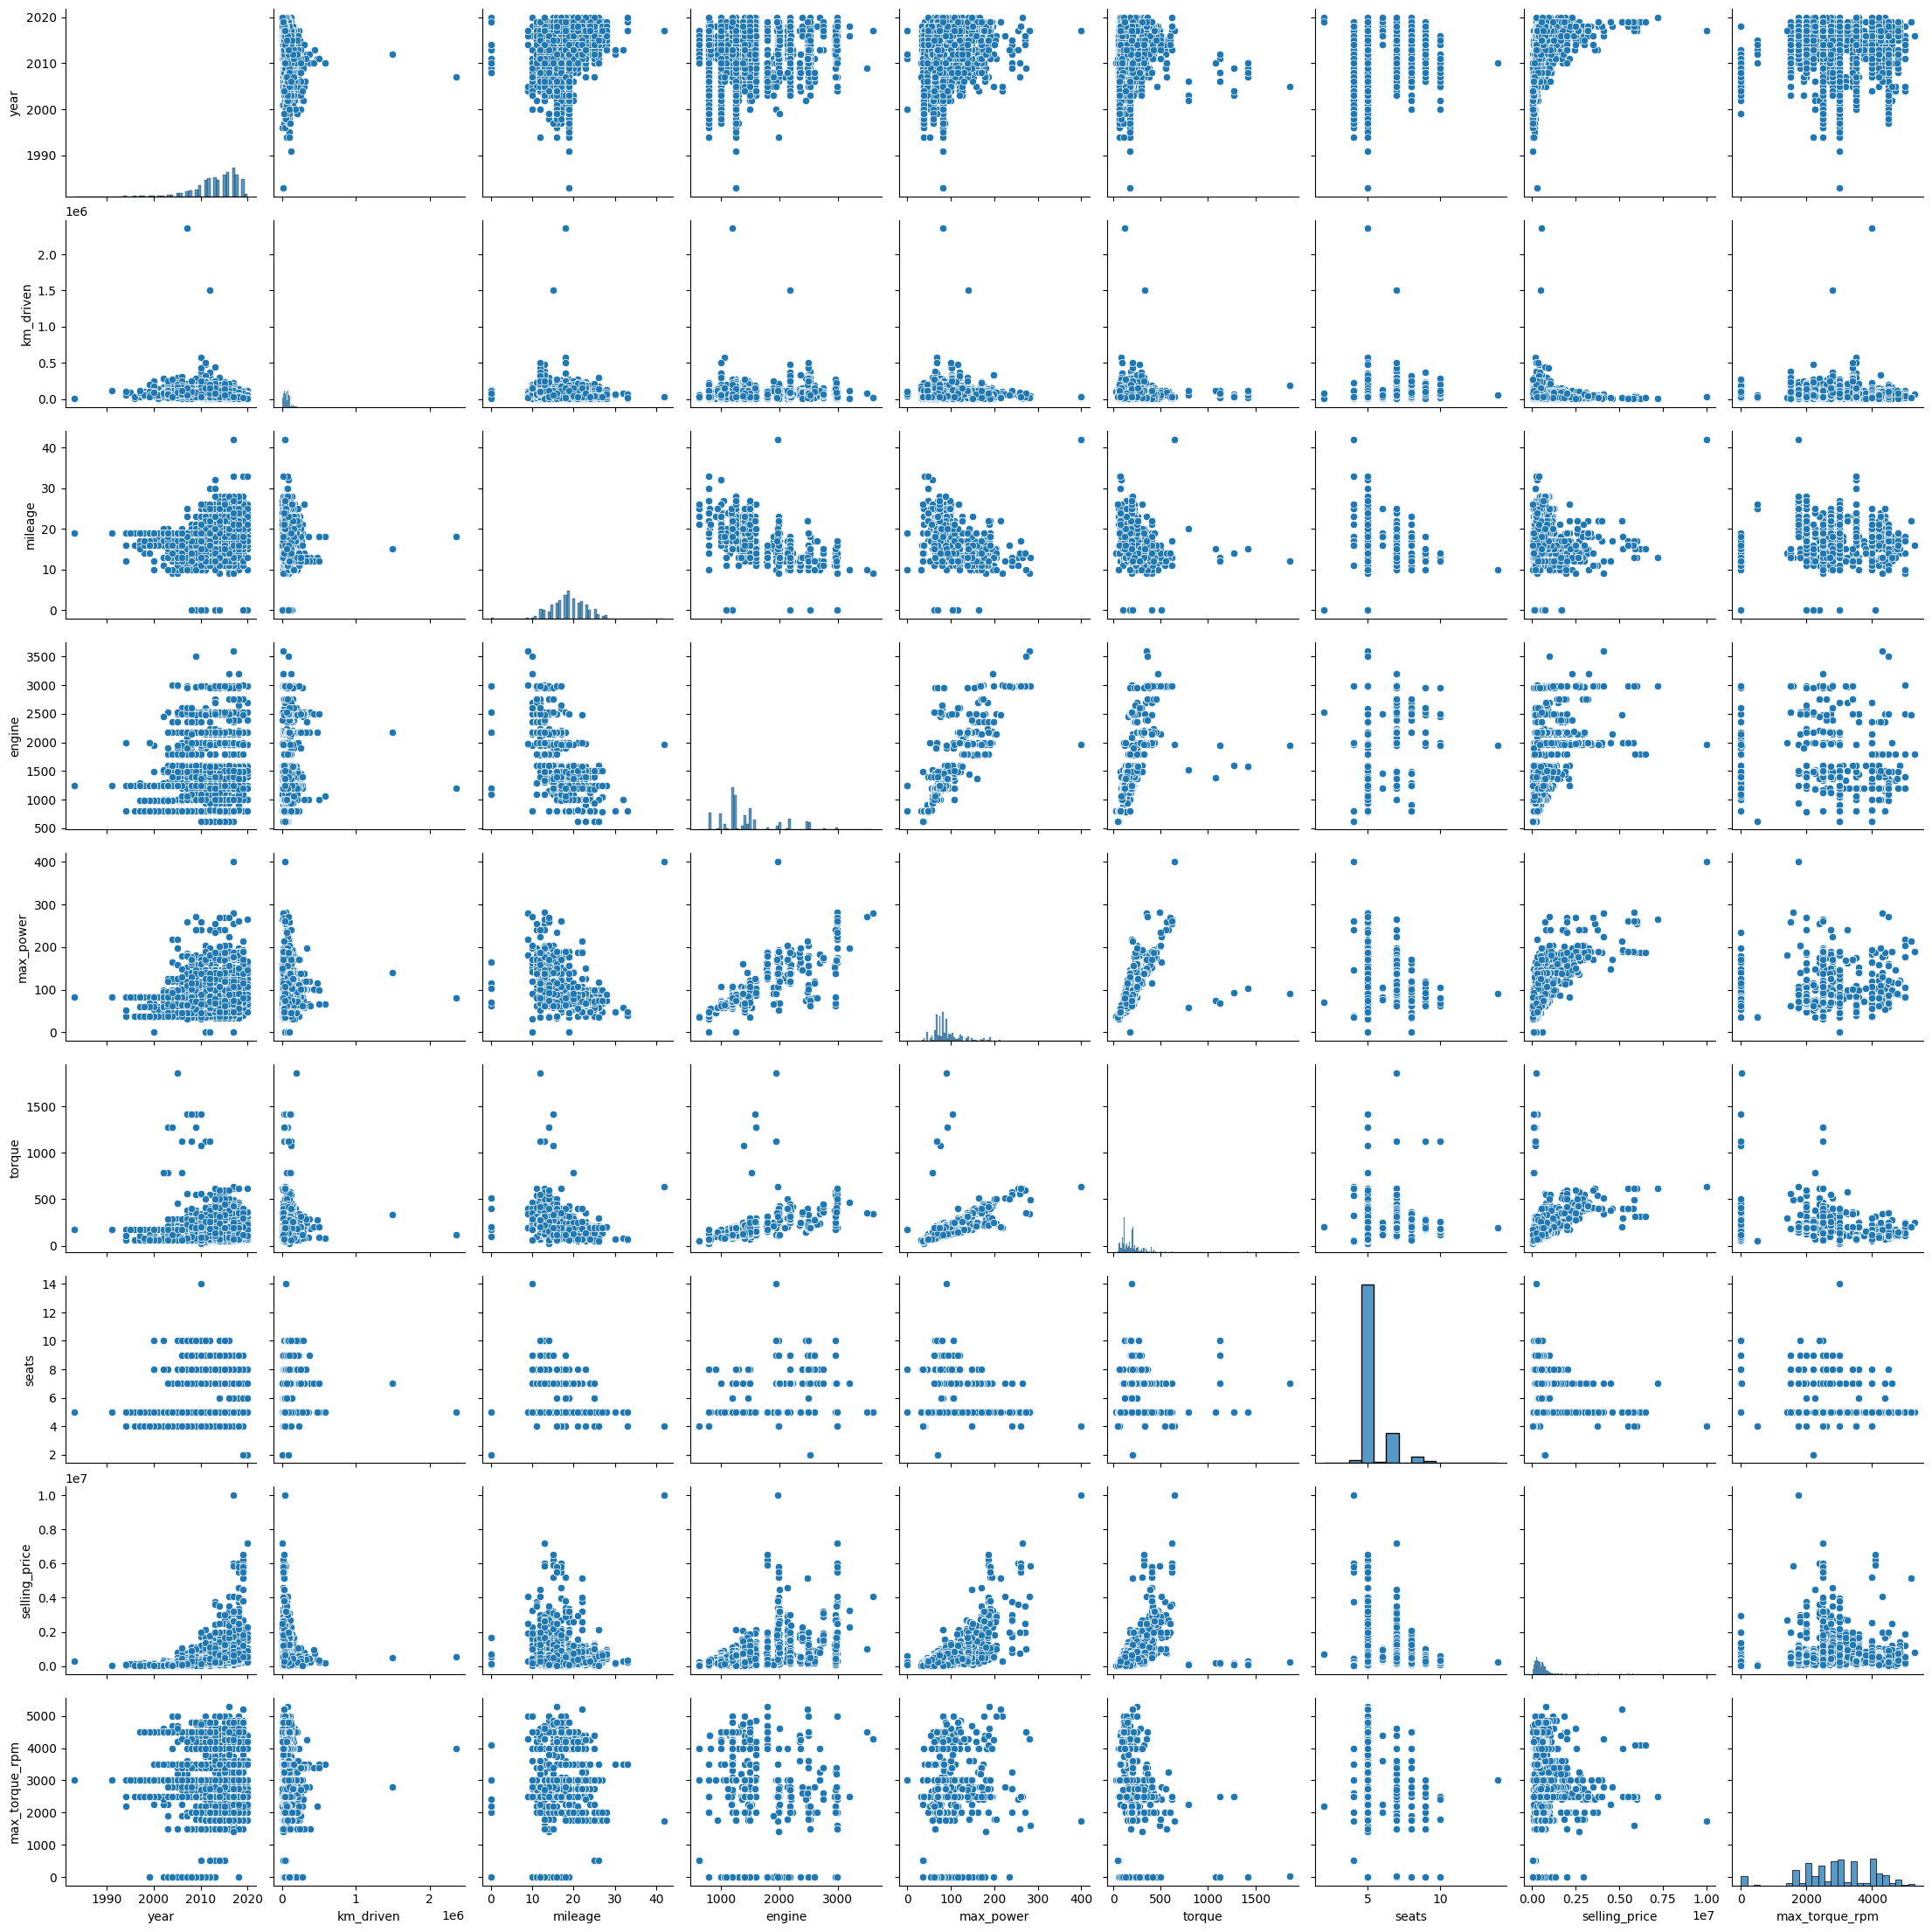

In [28]:
sns.pairplot(df_train)
plt.show()

```Линейной зависимости целевой переменной с признаками не наблюдается```

```Да, можно. Определенно есть корреляция между engine и max_power, также у max_power и torque, torque и engine```

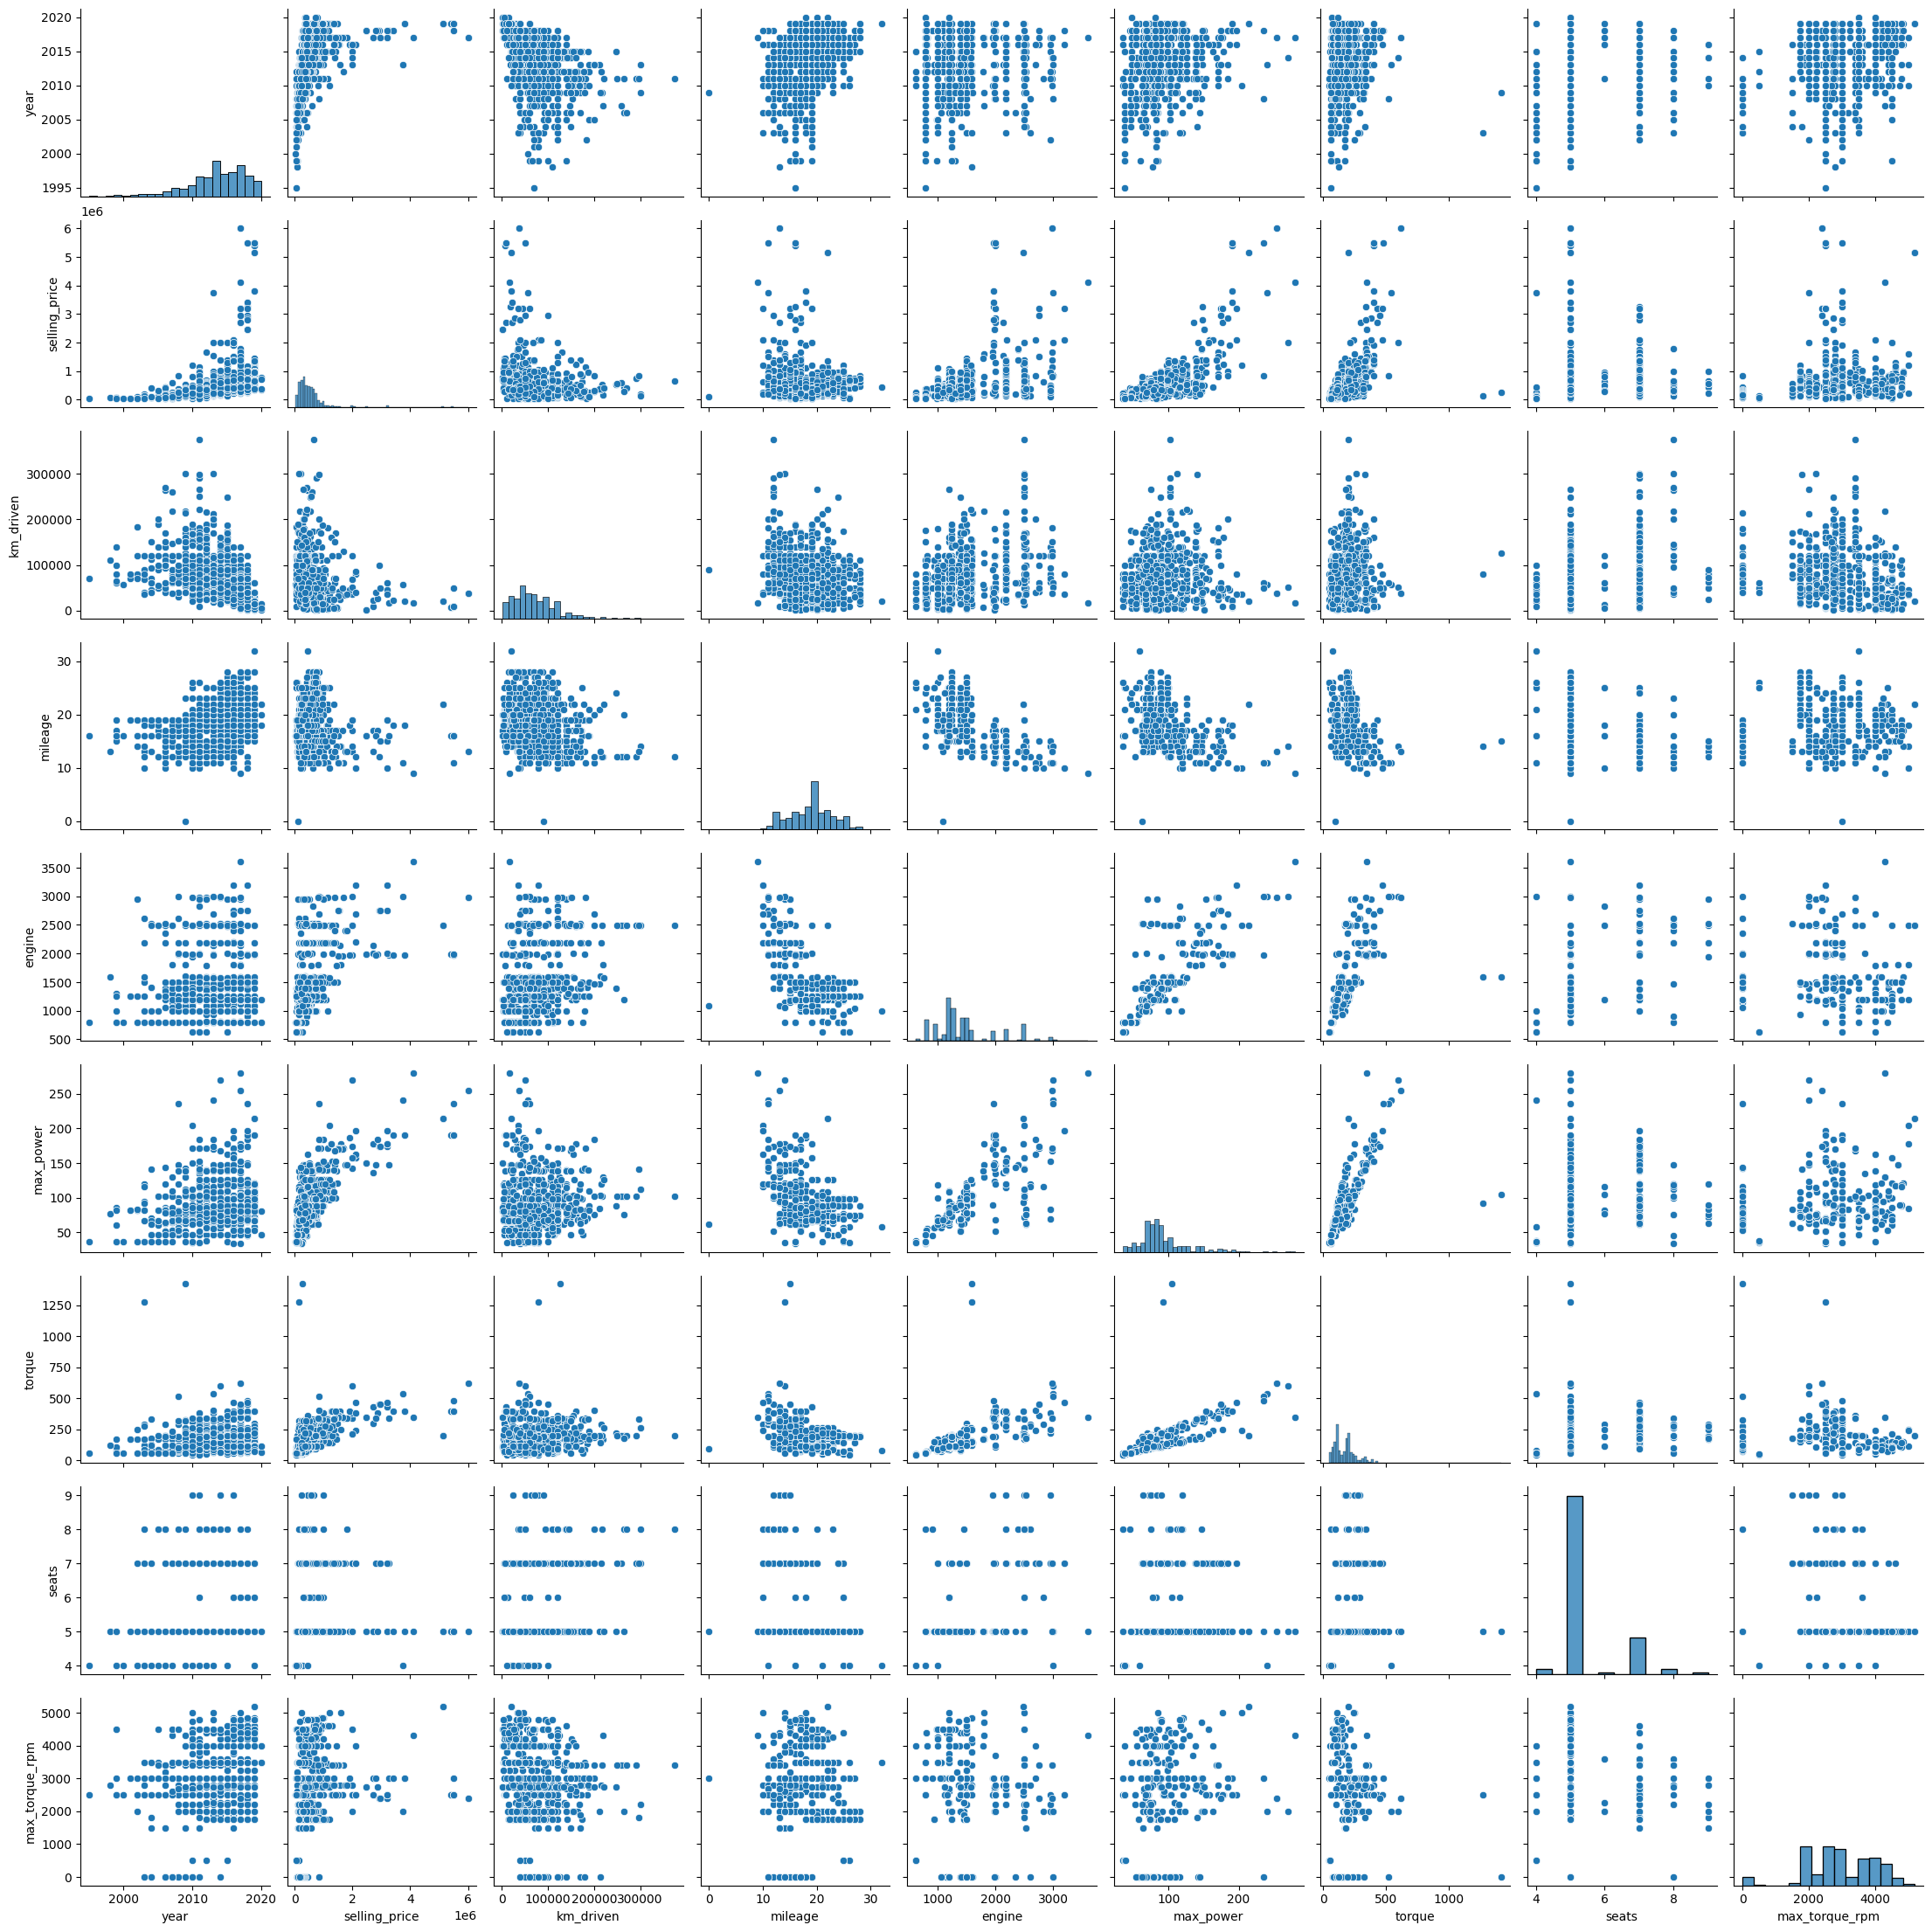

In [29]:
sns.pairplot(df_test)
plt.show()

`Какие то распределения схожи, а какие то нет. Не схожи как правило рсапределения, у которых наблюдается всего одно уникальное значение(engine, max_powermileage)`

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

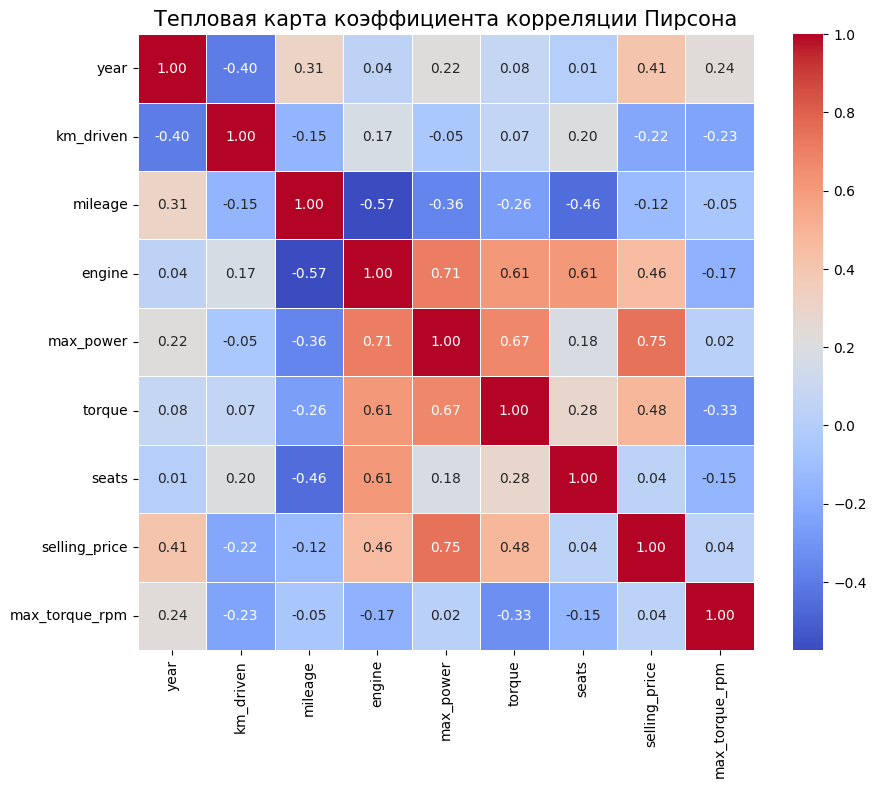

In [30]:
# your code here
correlation_matrix = df_train.corr(method='pearson', numeric_only=True)

# Построение тепловой карты
plt.figure(figsize=(10, 8))  # Устанавливаем размер фигуры
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)

# Настройка заголовка
plt.title('Тепловая карта коэффициента корреляции Пирсона', size=15)
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

`1) seats и year`

`2) selling_price и max_power`

`3) Да, суда по корреляции -0.4, хотя это очень странно`

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ]

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [31]:
# your code here
import numpy as np
from scipy.stats import spearmanr

def spearman_correlation_1(x, y):
    if len(x) != len(y):
        print("Ошибка: массивы должны быть одинаковой длины.")
        return None
    if len(x) < 2:
        print("Ошибка: массивы должны содержать как минимум два элемента.")
        return None
    
    n = len(x)
    rank_x = np.argsort(x).argsort()
    rank_y = np.argsort(y).argsort()

    d = rank_x - rank_y
    d_squared = d ** 2
    spearman_corr = 1 - (6 * np.sum(d_squared)) / (n * (n**2 - 1))

    return spearman_corr

### корреляция спирмана == корреляции пирсона рангов векторов
def spearman_correlation_2(x, y): # корр. спирмана при помощи коррю пирсона
    if len(x) != len(y):
        print("Ошибка: массивы должны быть одинаковой длины.")
        return None
    if len(x) < 2:
        print("Ошибка: массивы должны содержать как минимум два элемента.")
        return None
    
    n = len(x)
    rank_x = np.argsort(x).argsort()
    rank_y = np.argsort(y).argsort()
    spearman_corr = np.corrcoef(rank_x, rank_y)

    return spearman_corr


# Пример использования:
x = np.array([1, 3, 2, 4, 5, 8, 9, 10, 11])
y = np.array([1, 4, 3, 2, 5, 9, 8, 1, 11])

correlation_manual_1 = spearman_correlation_1(x, y)
correlation_manual_2 = spearman_correlation_2(x, y)
correlation_scipy, p_value = spearmanr(x, y)

print(f"Корреляция Спирмена (ручной расчет №1): {correlation_manual_1}")
print(f"Корреляция Спирмена (ручной расчет №2): {correlation_manual_2[0][1]}")
print(f"Корреляция Спирмена (scipy): {correlation_scipy}")

Корреляция Спирмена (ручной расчет №1): 0.5833333333333333
Корреляция Спирмена (ручной расчет №2): 0.5833333333333334
Корреляция Спирмена (scipy): 0.5272012675161055


In [32]:
df_train.dtypes

name               object
year                int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
mileage           float64
engine              int32
max_power         float64
torque            float64
seats               int32
selling_price       int64
max_torque_rpm    float64
dtype: object

interval columns not set, guessing: ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'selling_price', 'max_torque_rpm']


c:\Users\Vitaliy\AppData\Local\Programs\Python\Python310\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1773. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


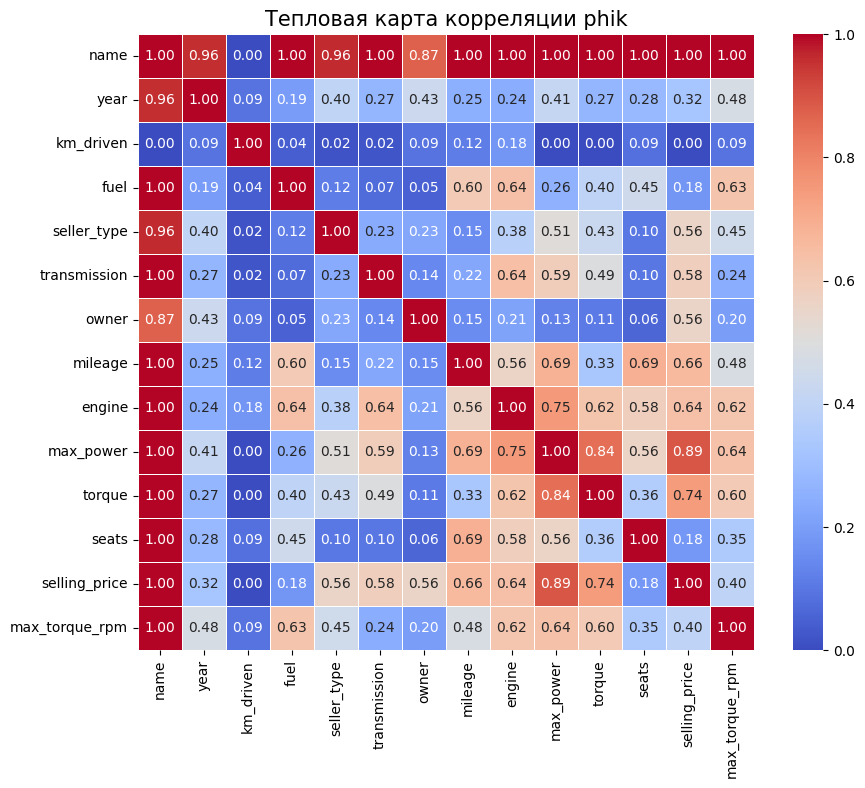

In [33]:
import phik
phik = df_train.phik_matrix()
plt.figure(figsize=(10, 8))  # Устанавливаем размер фигуры
sns.heatmap(phik, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)

# Настройка заголовка
plt.title('Тепловая карта корреляции phik', size=15)
plt.show()

In [34]:
df_train.name.nunique()

1773

In [35]:
x = np.array([1,3,5,4,2])
np.argsort(x)#.argsort()

array([0, 4, 1, 3, 2], dtype=int64)

` На тепловой карте phik корреляции коэффициенты корреляции выше, чем у корреляции Пирсона, это говорит о том, что между признаками есть нелинейная зависимость. Также можно увидеть корреляцию с категориальными и текстовыми фичами. Все они (кроме fuel) достаточно хорошо коррелируют с таргетом. Признак name имеет очень высокую корреляцию со всеми фичами, вероятно, это связано с тем, что в нем содержится слишком много уникальных занчений`

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

In [36]:
# your code here

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [45]:
from sklearn.model_selection import train_test_split

In [ ]:


numeric_df = df_train.select_dtypes(include=[np.number])
X, y = numeric_df.drop(['selling_price'], axis=1), numeric_df.selling_price
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# числовых признаков 8, так как torque и max_torque_rpm также перевел в числовые после преобразования

#assert X_train.shape == (5840, 6)
#assert X_test.shape == (1000, 6)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

In [ ]:


model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_val)

print("predict on test:")
print("r2:", r2_score(pred, y_val))
print("mse:", MSE(pred, y_val))
print()
print("predict on train")
pred_train = model.predict(X_train)
print("r2:", r2_score(pred_train, y_train))
print("mse:", MSE(pred_train, y_train))

predict on test:
r2: 0.33435033813072523
mse: 293806196491.5204

predict on train
r2: 0.43320968040584285
mse: 242979774425.6875


`Только по mse было бы непонятно насколько хороша модель в предсказании, но благодаря r2 видно, что модель еще далеко от идеальной, в целом ее предсказания не сильно лучше среднего(константного предсказания)`

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [40]:
import numpy as np

def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_mean) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

# Вычисление R^2
r2_value = r_squared(y_val, pred)

print(f"Коэффициент детерминации R^2: {r2_value}")

Коэффициент детерминации R^2: 0.6401852339883483


$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

Где:
$y_i$ — таргет,

$\hat{y}_i$ — предсказание на тесте,

$\bar{y}$ — среднее значение,

$n$ — количество наблюдений

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [41]:
# your code here
def r2_adjusted(y_true, y_pred, num_predictors):
    r2 = r_squared(y_true, y_pred)
    n = len(y_true)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    return adjusted_r2

r2_adj = r2_adjusted(y_val, pred, X_train.shape[1])
r2_adj

0.6377016117898209

`используется в ситуациях, когда мы добавляем дополнительные независимые переменные в модель. Если новая переменная не улучшает модель, значение r2_adjusted может снизиться, в отличие от обычного r2, которое может увеличиваться. Также помогает предотвратить ситуацию, когда модель слишком сложна`

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_val_sc = scaler.transform(X_val)

model = LinearRegression()
model.fit(X_train_sc, y_train)
pred = model.predict(X_val_sc)

print("predict on test:")
print("r2:", r2_score(pred, y_val))
print("mse:", MSE(pred, y_val))
print()
print("predict on train")
pred_train = model.predict(X_train_sc)
print("r2:", r2_score(pred_train, y_train))
print("mse:", MSE(pred_train, y_train))

predict on test:
r2: 0.33435033813073944
mse: 293806196491.51904

predict on train
r2: 0.43320968040585484
mse: 242979774425.68643


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [43]:
print(model.coef_)
print()
print(f"Самый важный признак = {X_train.columns[np.argmax(np.abs(model.coef_))]}")

[193290.97610189 -70273.94535978  16551.4177519   42240.90378592
 565353.15492947 -10129.91684423 -85174.97664862 -43959.36436612]

Самый важный признак = max_power


### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [44]:
from sklearn.linear_model import Lasso

model = Lasso()
model.fit(X_train_sc, y_train)
pred = model.predict(X_val_sc)
print("predict on test:")
print("r2:", r2_score(pred, y_val))
print("mse:", MSE(pred, y_val))
print()
print("predict on train")
pred_train = model.predict(X_train_sc)
print("r2:", r2_score(pred_train, y_train))
print("mse:", MSE(pred_train, y_train))
print()
print("коэффициенты lasso:")
print(model.coef_)

predict on test:
r2: 0.33434697341551334
mse: 293806350463.0243

predict on train
r2: 0.4332069545661329
mse: 242979774443.96344

коэффициенты lasso:
[193290.54474793 -70272.90324751  16549.78434713  42236.48580459
 565351.32731901 -10125.32036077 -85172.88680914 -43957.01754693]


`регуляризация недостаточно сильна. В модели Lasso регуляризация управляется параметром alpha, и если он установлен слишком низко, это может не создать достаточного давления для зануления весов менее значимых признаков. также совокупный эффект нескольких признаков (наличие корреляции между признаками) может быть очень важен для предсказания, и поэтому Lasso может не занулять их, так как завышенное нажатие на регуляризацию может привести к ухудшению точности модели`

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': np.logspace(-3, 5, 10),
    'max_iter': np.array([200,500, 1000, 2000])
}
model = Lasso()

grid_search = GridSearchCV(model, param_grid, cv=10, scoring='r2')
grid_search.fit(X_train_sc, y_train)

best_alpha = grid_search.best_params_['alpha']
best_max_iter = grid_search.best_params_['max_iter']
best_model = grid_search.best_estimator_
coefficients = best_model.coef_
best_score = grid_search.best_score_

print(f"Лучший коэффициент регуляризации (alpha): {best_alpha}")
print(f"Лучший коэффициент регуляризации (max_iter): {best_max_iter}")
print(f"Занулялись ли какие-либо веса? {np.any(coefficients == 0)}")
print(f"Количество моделей, обученных GridSearch: {len(grid_search.cv_results_['params'])}")
print(f"Лучший r2: {best_score}")

Лучший коэффициент регуляризации (alpha): 12915.496650148827
Лучший коэффициент регуляризации (max_iter): 200
Занулялись ли какие-либо веса? True
Количество моделей, обученных GridSearch: 40
Лучший r2: 0.6289413711840264


1) 40 моделей

2) alpha: Параметр регуляризации Lasso. Он контролирует силу регуляризации

    max_iter: Максимальное количество итераций

3) 12915, да

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [46]:
from sklearn.linear_model import ElasticNet

model = ElasticNet()

param_grid = {
    'alpha': np.logspace(-3, 5, 10),  
    'l1_ratio': np.linspace(0, 1, 10)  
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', 
                           cv=10, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_score = grid_search.best_score_
best_params = grid_search.best_params_
n_models_trained = len(grid_search.cv_results_['params'])

print(f"Лучшие параметры: {best_params}")
print(f"Лучший r2: {best_score}")
print(f"Количество обученных моделей: {n_models_trained}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Лучшие параметры: {'alpha': 0.001, 'l1_ratio': 1.0}
Лучший r2: 0.6280982868946093
Количество обученных моделей: 100


### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [21]:
from itertools import combinations
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae

In [48]:
numbers = list(range(20
                     ))
comb_lst = []
for r in range(len(numbers) + 1):
            for comb in combinations(numbers, r):
                comb_lst.append(comb)

len(comb_lst)

1048576

так как признаков немного, то реализуем полный перебор признаков

In [49]:
class MyRegressionModel(LinearRegression):
    def __init__(self, method) -> None: 
        super().__init__()
        if not method.lower() in ['aic', 'bic']:
            raise print("Не правильный тип L0")
        self.method = method
        self.model = LinearRegression()

    def generate_combination(self, num:int):
        numbers = list(range(num))
        comb_lst = []
        for r in range(len(numbers) + 1):
            for comb in combinations(numbers, r):
                comb_lst.append(comb)

        return comb_lst[1:]
    
    def calc_aic_bic(self, true, pred, k):
        sse = np.sum((true - pred)**2)
        n = len(true)
        sigma = sse / (n-2)
        aic = -2*np.log(sigma) + 2*k
        bic = -2*np.log(sigma) + 2*k*np.log(n)
        if self.method.lower() == 'aic':
            return aic
        else:
            return bic

    def fit(self, X, y):
        self.X = X
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        self.model.fit(X_train, y_train)
        pred = self.model.predict(X_val)
        #print(mae(pred, y_val), r2(pred, y_val))

        ic_best = self.calc_aic_bic(y_val, pred, X.shape[1])
        #print(ic_best)
        memory = []

        X_trn, X_v = X_train.copy(), X_val.copy()
        while True:
            lst_ic = []
            combination = self.generate_combination(num=X_trn.shape[1])
            #combination = combination[1:-1]
            # для каждой комбинации посчитаем aic, bic
            for elem in combination[:-1]:
                # if len(elem) == 0 or len(elem) == X_trn.shape[1]:
                #     lst_ic.append(10**10)
                #     continue
                X_sub = X_train.iloc[:, list(elem)]
                X_sub_val = X_val.iloc[:, list(elem)]
                self.model.fit(X_sub, y_train)
                pred = self.model.predict(X_sub_val)
                ic = self.calc_aic_bic(y_val, pred, len(elem))
                lst_ic.append(ic)
            # если aic лучше, то продолжаем, сохраняя индексы удаленных колонок, иначе выходим из while
            if lst_ic:
                mn = np.min(lst_ic)
                #print(mn)
                if mn >= ic_best:
                    break
            else:
                #print(lst_ic)
                break

            ic_best = mn
            
            ind = np.argmax(lst_ic)
            memory.append(list(combination[ind]))

            X_trn = X_trn.iloc[:, list(combination[ind])]
            X_v = X_v.iloc[:, list(combination[ind])]
        

        combination = self.generate_combination(num=X_trn.shape[1])
        if memory:
            for elem in memory:
                X_train = X_train.iloc[:, elem]
                X_val = X_val.iloc[:, elem]
                self.X_train = X_train.copy()

            self.model.fit(X_train, y_train)
        else:
            self.model.fit(X_train, y_train)
        
        self.y_train = y_train
        self.memory = memory

        return self
    
    @property
    def coef_(self):
        # добавление коэффициентов модели
        self.model.fit(self.X_train, self.y_train)
        self.coef = [] 
        i = 0
        for col in self.X.columns:
            if col in self.X_train.columns:
                self.coef.append(self.model.coef_[i])
                i+=1
            else:
                self.coef.append(0)
        return self.coef
            

    def predict(self, X):
        if self.memory:
            for elem in self.memory:
                X = X.iloc[:, elem]
        return self.model.predict(X)


my_model = MyRegressionModel(method='aic')
my_model.fit(X_train, y_train)
my_model.coef_
#pred = my_model.predict(X_val)

[54793.887746940905,
 0,
 3498.8893839952575,
 77.3851006412566,
 15443.949041917433,
 45.972392290430236,
 -98184.41256877163,
 -28.17326809287988]

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [22]:
# your code here
print(df_train.name.nunique(), df_train.name.apply(lambda x: x.split()[0]).nunique())
df_train['name'] = df_train.name.apply(lambda x: x.split()[0])
df_test['name'] = df_test.name.apply(lambda x: x.split()[0])

1773 30


In [23]:
from sklearn.preprocessing import TargetEncoder

enc = TargetEncoder(smooth="auto")
trn = enc.fit_transform(df_train[['name']], y)
tst = enc.transform(df_test[['name']])

df_train['name'] = trn
df_test['name'] = tst

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [52]:
df_train.nunique()

name                6
year               29
km_driven         723
fuel                4
seller_type         3
transmission        2
owner               5
mileage            25
engine            118
max_power         138
torque            232
seats               9
selling_price     575
max_torque_rpm     71
dtype: int64

In [53]:
#assert X_train_cat.shape == (5840, 11)

In [54]:
df_train.describe(include='object')

fuel seller_type transmission        owner
count     5840        5840         5840         5840
unique       4           3            2            5
top     Diesel  Individual       Manual  First Owner
freq      3151        4839         5068         3821

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [26]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas
df_train['seats'] = df_train['seats'].apply(lambda x: str(x))
df_test['seats'] = df_test['seats'].apply(lambda x: str(x))

cols = ['fuel','seller_type','transmission','owner', 'seats']
for col in cols:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    trn = ohe.fit_transform(df_train[[col]])[:, :-1]
    tst = ohe.transform(df_test[[col]])[:, :-1]
    with open(f'OHE_{col}.pkl', 'wb') as f:
        pickle.dump(ohe, f)


    columns = [f"{col}_{i}" for i in range(trn.shape[1])]

    df_train = pd.concat([df_train.drop(col, axis=1).reset_index(drop=True), pd.DataFrame(trn, columns=columns).reset_index(drop=True)], axis=1)
    df_test = pd.concat([df_test.drop(col, axis=1), pd.DataFrame(tst)])
    

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

1) количество категорий должно быть ограничено, не должно быть пропусков

2)  зная значения первых n-1 столбцов, можно однозначно определить значение n-ого

3) с одной стороны это кажется нелогично, так как признак был сформирован вместе с n-2 другими. Но раз он не несет никакой информации, то удалив его ничего не поменяется

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [46]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

X, y = df_train.drop(['selling_price'], axis=1), df_train.selling_price
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
'''scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_val_sc = scaler.transform(X_val)'''

'scaler = StandardScaler()\nscaler.fit(X_train)\nX_train_sc = scaler.transform(X_train)\nX_val_sc = scaler.transform(X_val)'

In [47]:
param_grid = {
    'alpha': np.logspace(-3, 5, 10)
}
model = Ridge()

grid_search = GridSearchCV(model, param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_
coefficients = best_model.coef_
best_score = grid_search.best_score_

print(f"Лучший коэффициент регуляризации (alpha): {best_alpha}")
print(f"Занулялись ли какие-либо веса? {np.any(coefficients == 0)}")
print(f"Количество моделей, обученных GridSearch: {len(grid_search.cv_results_['params'])}")
print(f"Лучший r2: {best_score}")

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.72459e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Vitaliy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.93794e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Vitaliy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.63158e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Vitaliy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.74317e-17): result may not be accurate.
  return lina

Лучший коэффициент регуляризации (alpha): 0.001
Занулялись ли какие-либо веса? False
Количество моделей, обученных GridSearch: 10
Лучший r2: 0.6920804187871428


c:\Users\Vitaliy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.39715e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [59]:
X_train.columns

Index(['name', 'year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'max_torque_rpm', 'fuel_0', 'fuel_1', 'fuel_2', 'seller_type_0',
       'seller_type_1', 'transmission_0', 'owner_0', 'owner_1', 'owner_2',
       'owner_3', 'seats_0', 'seats_1', 'seats_2', 'seats_3', 'seats_4',
       'seats_5', 'seats_6', 'seats_7'],
      dtype='object')

попробуем сгенерировтаь новые фичи

In [53]:
def add_features(data):
    X = data.copy()
    eps = 10**(-7)
    X['feature_1'] = X['km_driven'] / (X['year'] +eps)
    X['feature_2'] = X['year'] / (X['mileage'] + eps)
    X['feature_3'] = X['km_driven'] * X['mileage']
    X['feature_4'] = X['max_power'] * X['torque']
    X['feature_5'] = X['max_torque_rpm'] / (X['max_power'] + eps)
    X['feature_6'] = 1 / X['year']
    return X

def fit_predict(X_train, y_train, X_val, model):
    model.fit(X_train, y_train)
    return model.predict(X_val)

X_train_new = add_features(X_train)
X_val_new = add_features(X_val)

In [55]:
from sklearn.linear_model import ElasticNet

In [58]:
pred = fit_predict(X_train, y_train, X_val, ElasticNet())
r2_score(y_val, pred)

0.6572723188584493

In [60]:
model = ElasticNet()
pred = fit_predict(X_train_new, y_train, X_val_new, model)
r2_score(y_val, pred)

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.027e+14, tolerance: 3.138e+11
  model = cd_fast.enet_coordinate_descent(


0.7315357995787366

In [61]:
with open("model.pkl", 'wb') as f:
    pickle.dump(model, f)

удалось повысить качество!

теперь почистим данные от выбросов

In [63]:
NUM = 8 # в бинарных признаках нет смысла искать выбросы 
X_train.iloc[:, :NUM+1]

name  year  km_driven  mileage  engine  max_power  torque  \
5309  0.000000  2019       7032     19.0    1199       88.0  110.00   
1647  0.000000  2008     205000     19.0    1396       69.0  135.00   
1669  0.000000  2012      70000     16.0    1498       97.0  134.00   
3159  0.000697  2020      30000     22.0     796       47.0   69.00   
4575  0.000000  2010      65000     15.0    1193       64.0  100.00   
...        ...   ...        ...      ...     ...        ...     ...   
3772  0.000000  2017      45000     19.0    1999      177.0  430.00   
5191  0.000000  2015     140000     16.0    2179      140.0  330.00   
5226  0.000000  2020      32000     20.0    1197       81.0  113.75   
5390  0.000702  2017      79000     25.0    1248       88.0  200.00   
860   0.000000  2016      20000     25.0     799       53.0   72.00   

      max_torque_rpm  fuel_0  
5309          4800.0     0.0  
1647          2500.0     0.0  
1669          4000.0     0.0  
3159          3500.0     0.0  
4575          2700.0     0.0  
...              ...     ...  
3772          2500.0     0.0  
5191          2800.0     0.0  
5226          4000.0     0.0  
5390          1750.0     0.0  
860           4386.0     0.0  

[4672 rows x 9 columns]

отберем данные входящие в интервал: (Q1 - 1.5IQR, Q3 + 1.5IQR)

In [64]:
def compute_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    left = Q1 - 1.5*IQR
    right = Q3 + 1.5*IQR
    return left, right

X_train2 = X_train.copy()
print(X_train2.shape)
for col in X_val.columns[:NUM]:
    l, r = compute_iqr(X_train2[col])
    if l != r:
        X_train2 = X_train2[(X_train2[col] >= l) & (X_train2[col] <= r)]
print(X_train2.shape)

(4672, 26)
(3466, 26)


межквартильный размах определяет слишком много выбросов, попробуем убрать данные не попадающие в доверительный интервал трех сигм

In [65]:
from scipy.stats import zscore

X_train2 = X_train.copy()
print(X_train2.shape)
for col in X_val.columns[:NUM]:
    X_train2[col] = zscore(X_train2[col])
    # print(col)
    # print(X_train2[col].min(), X_train2[col].max())
    X_train2 = X_train2[(X_train2[col] < 3) & (X_train2[col] > -3)]

print(X_train2.shape)

(4672, 26)
(4409, 26)


In [66]:
dropped_rows = X_train.index.difference(X_train2.index)
y_train2 = y_train.drop(dropped_rows)
assert y_train2.shape[0] == X_train2.shape[0]

теперь после очистки данных от выбросов проверим качество сначала без добавление новых фичей, па потом с добавлением

In [67]:
pred = fit_predict(X_train2, y_train2, X_val, ElasticNet())
r2_score(y_val, pred)

-34231893.531192765

In [68]:
X_train_new2 = add_features(X_train2)

pred = fit_predict(X_train_new2, y_train2, X_val_new, ElasticNet())
r2_score(y_val, pred)

-1734853275751.5332

качество очень сильно упало, это интересный случай

Если посмотреть на 2 практически одинаковые выборки и обучить одинаковые модели, то мы получим сильное отличие в метриках. Вероятно, при чистке выбросов были удалены какие то важные объекты для модели

In [69]:
dropped_rows[:20]

Index([  6,  31,  42,  66, 118, 126, 129, 130, 146, 148, 165, 166, 277, 350,
       358, 361, 370, 412, 526, 547],
      dtype='int64')

In [70]:
pred = fit_predict(X_train2.iloc[:1743], y_train.iloc[:1743], X_val, ElasticNet())
print("r2 =", r2_score(y_val, pred))
print("mae =", mae(y_val, pred))

r2 = -289194.5505952064
mae = 431971425.77245265


In [71]:
pred = fit_predict(X_train_new.iloc[:734], y_train.iloc[:734], X_val_new, ElasticNet())
print("r2 =", r2_score(y_val, pred))
print("mae =", mae(y_val, pred))

r2 = 0.7111104614911787
mae = 232151.66131315258


c:\Users\Vitaliy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.833e+13, tolerance: 3.592e+10
  model = cd_fast.enet_coordinate_descent(


In [72]:
pred = fit_predict(X_train_new.iloc[750:], y_train.iloc[750:], X_val_new, ElasticNet())
print("r2 =", r2_score(y_val, pred))
print("mae =", mae(y_val, pred))

r2 = 0.7329978021094756
mae = 246878.50259369996


c:\Users\Vitaliy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.379e+14, tolerance: 2.776e+11
  model = cd_fast.enet_coordinate_descent(


# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [73]:
def business_metrics(y_true, y_pred):
    diff = (abs(y_pred - y_true) / y_true).reset_index(drop=True)
    return diff[diff <= 0.1].shape[0] / diff.shape[0]

business_metrics(y_val, pred)

0.18664383561643835

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [74]:
from sklearn.metrics import mean_squared_error as mse

In [75]:
def your_business_metrics(y_true, y_pred, lambda_w):
    mas = y_true - y_pred
    under_forecast = np.median(mas[mas > 0])
    over_forecast = -np.median(mas[mas < 0])
    mae_score = mae(y_true, y_pred)
    #print(under_forecast, over_forecast, mae_score)
    metric_value = (under_forecast*lambda_w + over_forecast) / (2*mae_score)

    return metric_value


your_business_metrics(y_val, pred, 4)

1.3370476574442038

# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [102]:
df_train.head(3)

name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2  22.4 kgm at 1750-2750rpm    5.0

In [2]:
from fastapi import FastAPI
from pydantic import BaseModel, Field
from typing import List, Annotated

app = FastAPI()


class Item(BaseModel):
    name: str
    year: Annotated[int, Field(strict=True, gt=0)]
    selling_price: Annotated[int, Field(strict=True, gt=0)]
    km_driven: Annotated[int, Field(strict=True, gt=0)]
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: Annotated[float, Field(strict=True, gt=0)]


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return 


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    return 

In [3]:
from devtools import pprint

sample = {"name":"Maruti Baleno Delta 1.2",
        "year":2016,
        "selling_price":1000000,
        "km_driven":45000,
        "fuel":'Petrol',
        "seller_type":"Individual",
        "transmission":"Manual",
        "owner":"First Owner",
        "mileage":"21.4 kmpl",
        "engine":"1197 CC",
        "max_power":"83.1 bhp",
        "torque":"115Nm@ 4000rpm",
        "seats":5.0}

In [4]:
item = Item(
    name="Maruti Baleno Delta 1.2",
    year=2016,
    selling_price=1000000,
    km_driven=45000,
    fuel='Petrol',
    seller_type="Individual",
    transmission='Manual',
    owner='First Owner',
    mileage='21.4 kmpl',
    engine='1197 CC',
    max_power='83.1 bhp',
    torque='115Nm@ 4000rpm',
    seats=5.0
)

Item.model_validate(sample)

Item(name='Maruti Baleno Delta 1.2', year=2016, selling_price=1000000, km_driven=45000, fuel='Petrol', seller_type='Individual', transmission='Manual', owner='First Owner', mileage='21.4 kmpl', engine='1197 CC', max_power='83.1 bhp', torque='115Nm@ 4000rpm', seats=5.0)

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>